# Packages


In [1]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv3D, BatchNormalization
from keras.layers import Conv3DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import UpSampling3D
from keras.activations import sigmoid
from matplotlib import pyplot
import os
from tifffile import imread, imsave, imwrite
from sys import stdout
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras import backend as K
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization
import xlwt
from xlwt import Workbook
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from torch.nn import ReflectionPad3d
import torch

/opt/conda/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Model


In [9]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)

    # C64
    d = Conv3D(64, 4, strides=2, padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv3D(128, 4, strides=2, padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv3D(256, 4, strides=2, padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv3D(512, 4, strides=2, padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv3D(512, 4, padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv3D(1, 4, padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001, beta_1=0.5), loss_weights=[0.5])
    return model

In [3]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv3D(n_filters, 3, padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv3D(n_filters, 3, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):

	# weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-32
    g = Conv3D(32, 7, padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d64
    g = Conv3D(64, 3, strides=2, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv3D(128, 3, strides=2, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(128, g)
    # u64
    g = Conv3DTranspose(64, 3, strides=2, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u32
    g = Conv3DTranspose(32, 3, strides=2, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-2
    g = Conv3D(3, 7, padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [4]:
def weighted_mean_absolute_error(class_weights):
    def loss(y_true, y_pred):
        mae = tf.keras.losses.MeanAbsoluteError()
        red_channel_loss = mae(y_true[:,:,:,:,0],y_pred[:,:,:,:,0])
        green_channel_loss = mae(y_true[:,:,:,:,1],y_pred[:,:,:,:,1])
        blue_channel_loss = mae(y_true[:,:,:,:,2],y_pred[:,:,:,:,2])
        return class_weights[0]*red_channel_loss+class_weights[1]*green_channel_loss+class_weights[2]*blue_channel_loss
    return loss

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape, class_weights=[3.5,1,1]):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(learning_rate=0.0005, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    wmae = weighted_mean_absolute_error(class_weights)

    model.compile(loss=['mse', wmae, wmae, wmae], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model


# Train


In [10]:
# load and prepare training images
def load_real_samples(dataset, ID, filename, dim):
    # load the dataset
    if dataset == '/Images/':
        dim = (64,64,64,3)
    X = np.empty((len(ID), *dim))

    for i, ID_path in enumerate(ID):
        X[i,] = imread(filename + dataset + ID_path)
        X[i,] = (X[i,] - 0.5) / 0.5
    
    return X


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_size, filename, n_patch):

	list_IDs = os.listdir(filename + dataset)
	# choose random instances
	indexes = randint(0, len(list_IDs), n_samples)
	list_IDs_temp = [list_IDs[k] for k in indexes]
	# retrieve selected images
	X = load_real_samples(dataset, list_IDs_temp, filename, patch_size)
	# generate 'real' class labels (1)
	y = ones((n_samples, n_patch, n_patch, 1))

	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# path to save models
	path_models = './Models_CycleGAN_3/'
	if os.path.exists(path_models)==False:
		os.mkdir(path_models)
	# save the first generator model
	filename1 = path_models + 'g_model_AtoB_%03d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = path_models + 'g_model_BtoA_%03d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s \n' % (filename1, filename2))
 

def thresholding(patch_prediction):
    patch_ind_nuclei = np.argwhere(patch_prediction[:,:,:,0] > 0.5)
    patch_ind_golgi = np.argwhere(patch_prediction[:,:,:,1] > 0.5)
    patch_ind_int = np.argwhere(patch_prediction[:,:,:,2] > 0.5)

    patch_prediction_thr = np.zeros((patch_prediction.shape[0],patch_prediction.shape[1],patch_prediction.shape[2],3))

    for i in range(patch_ind_nuclei.shape[0]):
      patch_prediction_thr[patch_ind_nuclei[i,0],patch_ind_nuclei[i,1],patch_ind_nuclei[i,2],0]=1 

    for j in range(patch_ind_golgi.shape[0]):
      patch_prediction_thr[patch_ind_golgi[j,0],patch_ind_golgi[j,1],patch_ind_golgi[j,2],1]=1
    
    for k in range(patch_ind_int.shape[0]):
      patch_prediction_thr[patch_ind_int[k,0],patch_ind_int[k,1],patch_ind_int[k,2],2]=1

    return patch_prediction_thr

def padding(image,size):
    
    img_reshape = np.moveaxis(image, -1, 0)
    
    m = ReflectionPad3d((0,size[2]-image.shape[2],0,size[1]-image.shape[1],0,size[0]-image.shape[0]))
    _input = torch.tensor(img_reshape, dtype=torch.float)
    output = m(_input)
    pad_img = output.numpy()
    pad_img = np.moveaxis(pad_img, 0, -1)
    
    return pad_img

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, name, patch_size, results_path, n_samples=5, filename= './Dataset_3/Patches_synthetic_64/Train'):
	# select a sample of input images
	X_in, _ = generate_real_samples(dataset, n_samples, patch_size, filename, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	a = np.zeros((n_samples, *(64,64,64,3)))
	for i in range(n_samples):
			a[i] = padding(X_in[i], (64,64,64,3))
	X_in = a
	#X_out = (X_out + 1) / 2.0
	if dataset == '/Masks/':
		a = np.zeros((n_samples, *(64,64,64,3)))
		for i in range(n_samples):
				a[i] = padding(X_out[i], (64,64,64,3))
		X_out = a
	# If its a segmentation mask we have to turn to RGB
	if dataset == '/Images/':
		a = np.empty((n_samples, *(64,64,64,3)))
		for i in range(n_samples):
			a[i] = thresholding(X_out[i])
		X_out = a
		

	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i,:,:,25,:])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i,:,:,25,:])
	# save plot to file
	filename1 = results_path + '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, filename, img_dim):
    # Results
    path = './Dataset_3/Results_CycleGAN/'
    if os.path.exists(path)==False:
        os.mkdir(path)
    # define properties of the training run
    n_epochs, n_batch = 100, 2
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    list_IDs = os.listdir(filename + '/Images/')
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(list_IDs) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    e = 1
    steps = 1
    print('Epoch {}/{}'.format(e,n_epochs))
    prev_g_loss1 = np.inf
    # manually enumerate epochs
    for i in range(n_steps):
		# select a batch of real samples
        X_realA, y_realA = generate_real_samples('/Images/', n_batch, img_dim, filename, n_patch)
        X_realB, y_realB = generate_real_samples('/Masks/', n_batch, img_dim, filename, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        # print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        stdout.write('\rBatch: {}/{} - dA[{:.4f},{:.4f}] - dB[{:.4f},{:.4f}] - g[{:.4f},{:.4f}]         '
                      .format(steps, bat_per_epo, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        stdout.flush()
        steps = steps + 1
        
        # evaluate the model performance every epoch and save the model if its better
        if (i+1) % (bat_per_epo * 1) == 0:

            #if g_loss1 < prev_g_loss1:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)
            #prev_g_loss1 = g_loss1
                
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, '/Images/', 'AtoB', img_dim, path)
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, '/Masks/', 'BtoA', img_dim, path)

            steps = 1
            e = e + 1
            print('\n Epoch {}/{} \n'.format(e,n_epochs))



# Main

In [6]:
img_shape = (64,64,64,3)
filename = './Dataset_3/Patches_synthetic_64/Train'
# generator: A -> B
g_model_AtoB = define_generator(img_shape)
# generator: B -> A
g_model_BtoA = define_generator(img_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(img_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(img_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, img_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, img_shape)

2022-10-14 07:59:10.691242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 07:59:10.696241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 07:59:10.696503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 07:59:10.696837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, filename, img_shape)

Epoch 1/100


2022-10-14 07:59:14.933655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-14 07:59:15.680989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-10-14 07:59:15.858859: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-14 07:59:15.859199: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-14 07:59:15.859221: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-10-14 07:59:15.859556: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-14 07:59:15.859600: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

Batch: 216/216 - dA[0.0361,0.2972] - dB[0.1007,0.1621] - g[98.8620,99.1547]           >Saved: ./Models_CycleGAN_3/g_model_AtoB_216.h5 and ./Models_CycleGAN_3/g_model_BtoA_216.h5 


 Epoch 2/100 

Batch: 216/216 - dA[0.0311,0.1339] - dB[0.3947,0.1186] - g[85.5386,83.0936]         >Saved: ./Models_CycleGAN_3/g_model_AtoB_432.h5 and ./Models_CycleGAN_3/g_model_BtoA_432.h5 


 Epoch 3/100 

Batch: 216/216 - dA[0.0101,0.0198] - dB[0.0294,0.0360] - g[72.4350,72.3601]         >Saved: ./Models_CycleGAN_3/g_model_AtoB_648.h5 and ./Models_CycleGAN_3/g_model_BtoA_648.h5 


 Epoch 4/100 

Batch: 216/216 - dA[0.0150,0.0467] - dB[0.1608,0.1628] - g[62.2404,62.5604]         >Saved: ./Models_CycleGAN_3/g_model_AtoB_864.h5 and ./Models_CycleGAN_3/g_model_BtoA_864.h5 


 Epoch 5/100 

Batch: 216/216 - dA[0.0187,0.0256] - dB[0.0120,0.0193] - g[56.3531,54.4520]         >Saved: ./Models_CycleGAN_3/g_model_AtoB_1080.h5 and ./Models_CycleGAN_3/g_model_BtoA_1080.h5 


 Epoch 6/100 

Batch: 216/216 - dA[0.0117

# Test Model


In [18]:
def padding(image,size):

    img_reshape = np.moveaxis(image, -1, 0)
    
    m = ReflectionPad3d((0,size[2]-image.shape[2],0,size[1]-image.shape[1],0,size[0]-image.shape[0]))
    input = torch.tensor(img_reshape, dtype=torch.float)
    output = m(input)
    pad_img = output.numpy()
    pad_img = np.moveaxis(pad_img, 0, -1)
    
    return pad_img

In [19]:
def thresholding(patch_prediction):
    patch_ind_nuclei = np.argwhere(patch_prediction[:,:,:,0] > 0.5)
    patch_ind_golgi = np.argwhere(patch_prediction[:,:,:,1] > 0.5)
    patch_ind_int = np.argwhere(patch_prediction[:,:,:,2] > 0.5)

    patch_prediction_thr = np.zeros((patch_prediction.shape[0],patch_prediction.shape[1],patch_prediction.shape[2],3))

    for i in range(patch_ind_nuclei.shape[0]):
        patch_prediction_thr[patch_ind_nuclei[i,0],patch_ind_nuclei[i,1],patch_ind_nuclei[i,2],0]=1 

    for j in range(patch_ind_golgi.shape[0]):
        patch_prediction_thr[patch_ind_golgi[j,0],patch_ind_golgi[j,1],patch_ind_golgi[j,2],1]=1
    
    for k in range(patch_ind_int.shape[0]):
        patch_prediction_thr[patch_ind_int[k,0],patch_ind_int[k,1],patch_ind_int[k,2],2]=1

    return patch_prediction_thr

In [20]:
def pred_mask(image, mask_shape):
    patch_size = 64
    step = 48

    pred_mask = np.zeros(((image.shape[0] // step)*step + patch_size,(image.shape[1] // step)*step + patch_size,64,3))
    _image = padding(image, ((image.shape[0] // step)*step + patch_size,(image.shape[1] // step)*step + patch_size,64,image.shape[3]))

    i = 0
    while i + patch_size <= _image.shape[0]:
        j = 0
        while j + patch_size <= _image.shape[1]:

            tst_patch = _image[i:i+patch_size, j:j+patch_size, :, :]
            tst_patch = np.array([(tst_patch - 127.5) / 127.5])
            preds_tst = my_model.predict(tst_patch)
            preds_tst = (preds_tst + 1) / 2.0
            pred_patch = preds_tst[0,:,:,:,:]
            pred_patch_thr = thresholding(pred_patch)

            pred_mask[i:i+patch_size, j:j+patch_size,:,0] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,0], pred_patch_thr[:,:,:,0], dtype = 'float32'))
            pred_mask[i:i+patch_size, j:j+patch_size,:,1] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,1], pred_patch_thr[:,:,:,1], dtype = 'float32'))
            pred_mask[i:i+patch_size, j:j+patch_size,:,2] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,2], pred_patch_thr[:,:,:,2], dtype = 'float32'))

            j += step

        i += step

    _pred_mask = np.zeros(mask_shape)
    _pred_mask = pred_mask[0:mask_shape[0],0:mask_shape[1],0:mask_shape[2],:]

    return _pred_mask

In [21]:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def precision(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return(K.sum(flat_y_true * flat_y_pred) / K.sum(flat_y_pred) )

def recall(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return(K.sum(flat_y_true * flat_y_pred) / K.sum(flat_y_true) )

In [22]:
def metrics(mask, _pred_mask):
  _mask = mask/255.

  dice_coef_int = dice_coefficient(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  dice_coef_nuclei = dice_coefficient(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  dice_coef_golgi = dice_coefficient(_mask[:,:,:,0],_pred_mask[:,:,:,0])
  prec_int = precision(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  prec_nuclei = precision(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  prec_golgi = precision(_mask[:,:,:,0],_pred_mask[:,:,:,0])
  recall_int = recall(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  recall_nuclei = recall(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  recall_golgi = recall(_mask[:,:,:,0],_pred_mask[:,:,:,0])

  return [round(dice_coef_nuclei.numpy(),4), round(dice_coef_golgi.numpy(),4),round(dice_coef_int.numpy(),4), 
          round(prec_nuclei.numpy(),4), round(prec_golgi.numpy(),4),round(prec_int.numpy(),4), round(recall_nuclei.numpy(),4),
          round(recall_golgi.numpy(),4), round(recall_int.numpy(),4)]


In [23]:
def write_to_excel(wb,sheet_name,metrics, result_dir):

  # add_sheet is used to create sheet.
  sheet1 = wb.add_sheet(sheet_name)

  sheet1.write(0, 0, 'Dice Coeffient Nuclei')
  sheet1.write(0, 1, 'Dice Coeffient Golgi')
  sheet1.write(0, 2, 'Dice Coeffient Intersection')
  sheet1.write(0, 3, 'Precision Nuclei')
  sheet1.write(0, 4, 'Precision Golgi')
  sheet1.write(0, 5, 'Precision Intersection')
  sheet1.write(0, 6, 'Recall Nuclei')
  sheet1.write(0, 7, 'Recall Golgi')
  sheet1.write(0, 8, 'Recall Intersection')
  sheet1.write(1, 0, metrics[0])
  sheet1.write(1, 1, metrics[1])
  sheet1.write(1, 2, metrics[2])
  sheet1.write(1, 3, metrics[3])
  sheet1.write(1, 4, metrics[4])
  sheet1.write(1, 5, metrics[5])
  sheet1.write(1, 6, metrics[6])
  sheet1.write(1, 7, metrics[7])
  sheet1.write(1, 8, metrics[8])

  wb.save(result_dir + '/results_metrics.xlsx')


In [24]:
def test_model(base_dir):

    fnames = os.listdir(base_dir + 'Images/')

    # Workbook is created
    wb = Workbook()

    result_dir = './Dataset_3/Results_CycleGAN'
    if os.path.exists(result_dir)==False:
        os.mkdir(result_dir)

    for i in range(len(fnames)):
        
        image = imread(base_dir + 'Images/' + fnames[i])
        mask = imread(base_dir + 'Masks/' + fnames[i])

        predicted_mask = pred_mask(image, image.shape)

        _predicted_mask = predicted_mask*255.0
        _predicted_mask = _predicted_mask.astype('uint8')

        imwrite(result_dir + '/pred_mask_' + fnames[i] , _predicted_mask, photometric='rgb')

        _metrics = metrics(mask, predicted_mask)

        write_to_excel(wb,'Sheet_' + fnames[i].split('.')[0], _metrics, result_dir)

In [25]:
#Load the pretrained model for testing and predictions. 

#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('./Models_CycleGAN_3/g_model_AtoB_8208.h5', compile=False, custom_objects={'InstanceNormalization':InstanceNormalization})
#If you load a different model do not forget to preprocess accordingly. 

base_dir = './Dataset_3/Patches_synthetic_64/Test/'

test_model(base_dir)

# Pre-Processing

In [10]:
def pre_processing(filename, dataset):
    
    list_IDs_mask = os.listdir(filename + dataset)
    list_IDs_images = os.listdir(filename + '/Images/')
    i = 0
    j = 0

    for ID in list_IDs_mask:
        X = imread(filename + dataset + ID)[:,:,:,0]
        
        is_all_zeros = np.all((X == 0))
        
        if is_all_zeros:
            #os.remove(filename + dataset + ID)
            print("File",ID,"deleted mask")
            j = j+1
            
    for ID in list_IDs_images:
        y = imread(filename + '/Images/' + ID)[:,:,:,0]
        is_all_low = np.all((y <= (200/255.)))
            
        if is_all_low:
            #os.remove(filename + '/Images/' + ID)
            print("File",ID,"deleted image")
            i = i+1
            
    print(len(list_IDs_mask), j)
    print(len(list_IDs_images), i)
        

In [11]:
import os
pre_processing('./Dataset_3/Patches_synthetic_64/Train', '/Masks/')
list_IDs = os.listdir('./Dataset_3/Patches_synthetic_64/Train' + '/Masks/')
print(len(list_IDs))
list_IDs_ = os.listdir('./Dataset_3/Patches_synthetic_64/Train' + '/Images/')
print(len(list_IDs_))

File img_patch_644.tif deleted mask
File img_patch_124.tif deleted mask
File img_patch_564.tif deleted mask
File img_patch_518.tif deleted mask
File img_patch_438.tif deleted mask
File img_patch_252.tif deleted mask
File img_patch_161.tif deleted mask
File img_patch_563.tif deleted mask
File img_patch_588.tif deleted mask
File img_patch_551.tif deleted mask
File img_patch_321.tif deleted mask
File img_patch_50.tif deleted mask
File img_patch_145.tif deleted mask
File img_patch_437.tif deleted mask
File img_patch_528.tif deleted mask
File img_patch_547.tif deleted mask
File img_patch_128.tif deleted mask
File img_patch_443.tif deleted mask
File img_patch_444.tif deleted mask
File img_patch_34.tif deleted mask
File img_patch_375.tif deleted mask
File img_patch_118.tif deleted mask
File img_patch_225.tif deleted mask
File img_patch_31.tif deleted mask
File img_patch_631.tif deleted mask
File img_patch_338.tif deleted mask
File img_patch_32.tif deleted mask
File img_patch_647.tif deleted m

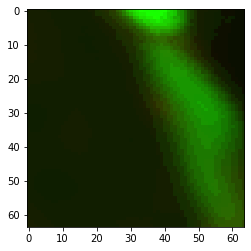

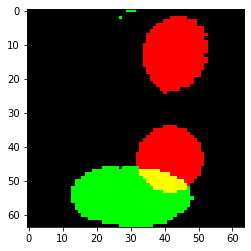

In [16]:
a = imread('./Dataset/Patches_synthetic/Train' + '/Images/' + 'img_patch_110.tif')
plt.figure(1)
imshow(a[:,:,30,:])
c = imread('./Dataset/Patches_synthetic/Train' + '/Masks/' + 'img_patch_110.tif')
b = np.zeros((64,64,64,3))
b[:,:,:,:2] = c
plt.figure(2)
imshow(b[:,:,30,:])

In [18]:
n_patches = 37

for i in range(n_patches):
    patch = np.zeros((64,64,64,2), dtype='float32')
    imwrite('./Dataset/Patches_synthetic/Train/Masks' + '/img_patch_' + str(7) + str(i) + '.tif', patch)
